# Darcy equation in a fractured domain: exercise 1

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unknowns are the velocity $q$ and the pressure $p$.

We consider now the solution of a single-phase flow problem in a fractured porous media. The fractures are represented by grids of one dimension lower than the porous media, fracture intersections are represented as well as 2 co-dimensional objects and (in 3d) intersections of fracture intersections are represented by point. This approach is usually called mixed-dimensional approach.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. The fracture $\gamma$ is given by its two ending points as
$$
    x_0 = (0.2, 0.2) \quad \text{and} \quad x_1 = (0.9, 1)
$$

Given 
$k_\Omega=I$ and $k_\gamma$ the matrix and fracture permeabilities, and $\psi_\Omega = \psi_\gamma = 0$ the source terms for both the rock matrix and fracture. The fracture aperture $\epsilon_\gamma = 1e-3$.
We want to solve the following problem:
find $({q}_\Omega, p_\Omega)$ in
$\Omega$ and $({q}_\gamma, p_\gamma)$ in $\gamma$ such that
$$
    \left\{
    \begin{array}{ll}
    \begin{array}{l} 
        \mu {q}_{\Omega} + {K}_{\Omega} \nabla
        p_{\Omega} = {0}\\
        \nabla \cdot {q}_{\Omega} = \psi_{\Omega}
    \end{array}
    &\text{in } \Omega
    \end{array}
    \right.
$$
$$
    \left\{
    \begin{array}{ll}
    \begin{array}{l} 
        \mu {q}_\gamma + \epsilon_\gamma {k}_\gamma \nabla p_\gamma = {0}\\
        \nabla_\gamma \cdot {q} = \psi_\gamma
    \end{array}
    &\text{in }\gamma
    \end{array}
    \right.
$$
with coupling conditions between the fracture and the surrounding matrix as
$$
    \left\{
    \begin{array}{ll}
    \begin{array}{l} 
        \mu \epsilon_\gamma {q}_{\Omega_+} \cdot {n} |_{\gamma_+}+
        {2}
        \kappa_\gamma ( p_{\Omega_+}|_{\gamma_+} - p_\gamma) = 0\\
        \mu \epsilon_\gamma {q}_{\Omega_-} \cdot {n} |_{\gamma_-}+
        {2}
        \kappa_\gamma (p_\gamma - p_{\Omega_-}|_{\gamma_-}) = 0
    \end{array}
    &\text{in }\gamma
    \end{array}
    \right.
$$
with boundary conditions for both the rock matrix and fracture as
$$ p = 0 \text{ on } \partial_{right} \Omega \qquad p = 1 \text{ on } \partial_{left} \Omega \qquad \nu \cdot q = 0 \text{ on } \partial_{top} \Omega \cup \partial_{bottom} \Omega$$

We consider two different behavior of the fracture: highly permeable, by setting $k_\gamma = 1e5$, and low permeable, by setting $k_\gamma = 1e-5$.


We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.


Let us start by importing the modules for the computation.

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

ModuleNotFoundError: No module named 'pygeon'

For simplicity in the presentation, we consider only bi-dimensional problems. The extension to three-dimensions is quite immediate. Fractures are represented as a fracture network and can imported from a file or created on-the-fly by setting their ending points.

In [2]:
# Define a rectangular domain in terms of range in the two dimensions
bounding_box = {"xmin": 0, "xmax": 1, "ymin": 0, "ymax": 1}
domain = pp.Domain(bounding_box=bounding_box)

# Define a fracture
frac1 = pp.LineFracture(np.array([[0.2, 0.9], [0.2, 1]]))

# Define a fracture network in 2d
network = pp.create_fracture_network([frac1], domain)

# Show graphically the domain and the fracture
network.plot()

AttributeError: module 'porepy' has no attribute 'Domain'

We create now a computational grid associated to the problem, by setting the mesh size we can create the corresponding mixed-dimensional grid. The latter is a collection of grids represented as a graph, where the nodes are the grids and the edges between notes are interfaces that connect the higher-dimensional with the lower-dimensional grids.

In [3]:
# Set overall target cell size and target cell size close to the fracture.
mesh_args = {"cell_size": 0.25 * 100, "cell_size_fracture": 0.3 * 100}

# Generate a mixed-dimensional grid
mdg = pp.create_mdg("simplex", mesh_args, network)

sd_old = mdg.subdomains(dim=2)[0]

print(sd_old.num_cells)
import copy

sd_new = copy.deepcopy(sd_old)

i1 = mdg.interfaces()[0].primary_to_mortar_avg().todense()

mg_old = mdg.interfaces()[0]
mg_new = copy.deepcopy(mg_old)

print(mdg.subdomains())

mdg.replace_subdomains_and_interfaces({sd_old: sd_new}, {mg_old: mg_new})

i2 = mdg.interfaces()[0].primary_to_mortar_avg().todense()

print(mdg.subdomains())


import matplotlib.pyplot as plt

plt.spy(i1 - i2)  # mass, div, spp
plt.show()

print(i1.shape, np.abs(i1 - i2).sum())

pg.convert_from_pp(mdg)
mdg.compute_geometry()

print(mdg)

AttributeError: module 'porepy' has no attribute 'create_mdg'

We can also visualize the mixed-dimensional grid.

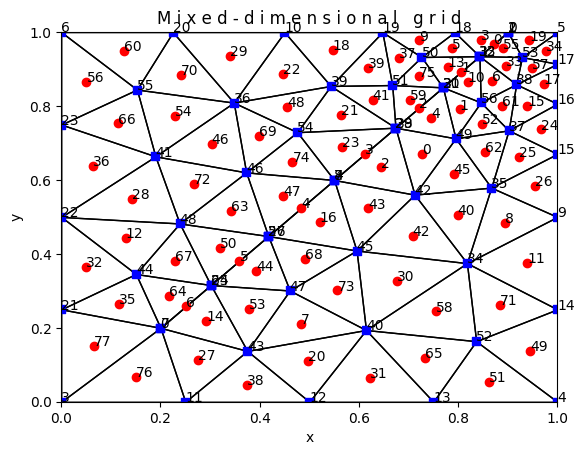

In [ ]:
pp.plot_grid(mdg, info="cn", plot_2d=True, alpha=0)

We introduce now the data to solve a single-phase flow problem, in particular we assume that the fracture is highly-permeable compared to the surrounding porous media. For doing this, we loop on all the grid and the associated data of the grid bucket, in this case the matrix grid and the fracture grid. Here we proceed as before, by adding the specific properties of the problem.

In [ ]:
key = "flow"
bc_val = []
bc_ess = []

# Fracture data
aperture = 1e-3
fracture_perm = 1e5  # 1e5 1e-5

# declare the discretization objects, useful to setup the data
RT0 = pg.RT0(key)
P0 = pg.PwConstants(key)

scalar_source = []
for sd, data in mdg.subdomains(return_data=True):
    if sd.dim == 1:
        # effective permeability for the fracture
        perm = pp.SecondOrderTensor(aperture * fracture_perm * np.ones(sd.num_cells))
    else:
        # unitary permeability tensor for the rock matrix
        perm = pp.SecondOrderTensor(np.ones(sd.num_cells))

    parameters = {
        "second_order_tensor": perm,
    }
    pp.initialize_data(sd, data, key, parameters)

    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    left = np.isclose(sd.face_centers[0, :], 0)
    right = np.isclose(sd.face_centers[0, :], 1)
    left_right = np.logical_or(left, right)

    top = np.isclose(sd.face_centers[1, :], 0)
    bottom = np.isclose(sd.face_centers[1, :], 1)
    top_bottom = np.logical_or(top, bottom)

    # compute the pressure boundary condition, which is a natural condition for the RT0 space
    def p_bc(x):
        return 1 - x[0]

    bc_val.append(-RT0.assemble_nat_bc(sd, p_bc, left_right))
    bc_ess.append(top_bottom)

ess_p_dofs = np.zeros(mdg.num_subdomain_cells(), dtype=bool)
bc_ess.append(ess_p_dofs)

We consider now the interface between the fracture and the porous media, we can set additional data that govern the flow exchange between them, which is the normal permeability.

In [ ]:
for mg, d in mdg.interfaces(return_data=True):
    kn = fracture_perm / (aperture / 2)
    pp.initialize_data(mg, d, key, {"normal_diffusivity": kn})

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation is given as
$$
\left(
\begin{array}{cc} 
M & -B^\top\\
B & 0
\end{array}
\right)
\left(
\begin{array}{c} 
q\\ 
p
\end{array}
\right)
=\left(
\begin{array}{c} 
0\\ 
f
\end{array}
\right)
$$<br>
$q$ now collects all the flux degrees of freedom for the rock matrix and fracture, similarly $p$ collects all the pressure degrees of freedom for the rock matrix and fracture.

To construct the saddle-point problem, we rely on the `scipy.sparse` function `bmat`. Once the matrix is created, we also construct the right-hand side containing the source term.

In [ ]:
# construct the local matrices
mass = pg.face_mass(mdg, keyword=key)
div = pg.cell_mass(mdg) @ pg.div(mdg)

# assemble the saddle point problem
spp = sps.bmat([[mass, -div.T], [div, None]], format="csc")

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape

# assemble the right-hand side
rhs = np.zeros(dof_p + dof_q)
rhs[:dof_q] += np.hstack(bc_val)

Let us use the command `spy` to discover the structure of the matrix `spp`.

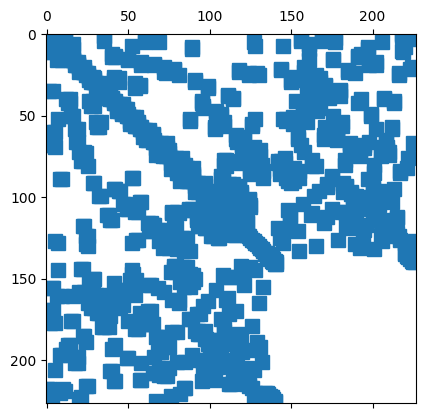

In [ ]:
import matplotlib.pyplot as plt

plt.spy(spp)  # mass, div, spp
plt.show()

We need to solve the linear system, PyGeoN provides a framework for that. Once the problem is solved, we extract the two solutions $q$ and $p$.

In [ ]:
# solve the problem
ls = pg.LinearSystem(spp, rhs)
ls.flag_ess_bc(np.hstack(bc_ess), np.zeros(dof_q + dof_p))
x = ls.solve()

# extract the variables
q = x[:dof_q]
p = x[-dof_p:]

Since the computed $q$ is one value per facet of the grid, for visualization purposes we project the flux in each cell center as vector. First, we need to access the corresponding degrees of freedoms for each domain.
We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [ ]:
# post process variables
dof_q_loc = np.zeros(2, dtype=int)
dof_p_loc = np.zeros(2, dtype=int)

for sd, data in mdg.subdomains(return_data=True):
    # select the current dofs
    dof_q_loc = dof_q_loc[1] + [0, sd.num_faces]
    dof_p_loc = dof_p_loc[1] + [0, sd.num_cells]

    # extract the local solutions
    q_loc = q[dof_q_loc[0] : dof_q_loc[1]]
    p_loc = p[dof_p_loc[0] : dof_p_loc[1]]

    # compute the solution over each cell
    proj_q = RT0.eval_at_cell_centers(sd)
    cell_q = (proj_q @ q_loc).reshape((3, -1), order="F")
    cell_p = P0.eval_at_cell_centers(sd) @ p_loc

    # save the variables to be exported
    pp.set_solution_values("cell_q", cell_q, data, 0)
    pp.set_solution_values("cell_p", cell_p, data, 0)

save = pp.Exporter(mdg, "sol", folder_name="ex1")
save.write_vtu(["cell_q", "cell_p"])